In [97]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [98]:
df = pd.read_excel("Sample - Superstore.xls")
tech = df.loc[df['Category'] == 'Technology']
tech['Order Date'].min(), tech['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [99]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Customer ID', 'Customer Name',  'Country', 'State', 'Postal Code', 'City', 'Product ID', 'Category', 'Product Name', 'Quantity', 'Profit']
tech.drop(cols, axis=1, inplace=True)
tech = tech.sort_values('Order Date')
tech.isnull().sum()

Order Date      0
Ship Mode       0
Segment         0
Region          0
Sub-Category    0
Sales           0
Discount        0
dtype: int64

In [100]:
num_cols = ['Sales','Discount']
tech[num_cols].corr()
#Low correlation of discount with sales column

,Sales,Discount
Sales,1.00000,0.04148
Discount,0.04148,1.00000


In [101]:
import seaborn as sns
cat_cols = ['Ship Mode','Segment','Region','Sub-Category']
for i in cat_cols:
    print(tech[i].unique())
tech_tr = pd.get_dummies(tech)
tech_tr.corr()['Sales']
#selecting subcategory as exogenous variable as it has good correlation with y compared to other features

['Standard Class' 'Second Class' 'First Class' 'Same Day']
['Home Office' 'Consumer' 'Corporate']
['South' 'Central' 'East' 'West']
['Phones' 'Accessories' 'Machines' 'Copiers']


Order Date                 -0.012027
Sales                       1.000000
Discount                    0.041480
Ship Mode_First Class       0.004100
Ship Mode_Same Day          0.034342
Ship Mode_Second Class     -0.028762
Ship Mode_Standard Class    0.004573
Segment_Consumer           -0.023582
Segment_Corporate          -0.004638
Segment_Home Office         0.035813
Region_Central             -0.022984
Region_East                 0.024526
Region_South                0.021565
Region_West                -0.020016
Sub-Category_Accessories   -0.181609
Sub-Category_Copiers        0.308027
Sub-Category_Machines       0.277319
Sub-Category_Phones        -0.070833
Name: Sales, dtype: float64

In [102]:
tech.drop(columns=['Ship Mode','Segment','Region','Discount'],inplace=True)

In [103]:
tech = tech.groupby(['Sub-Category','Order Date'])['Sales'].sum().reset_index()

In [104]:
tech = tech.set_index('Order Date')
tech.index
#very few values in weekly data hence setting the frequency to month

DatetimeIndex(['2014-01-09', '2014-01-13', '2014-01-15', '2014-02-01',
               '2014-02-07', '2014-02-11', '2014-02-14', '2014-02-20',
               '2014-03-02', '2014-03-05',
               ...
               '2017-12-14', '2017-12-15', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-25', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1255, freq=None)

In [105]:
tech_tr = pd.get_dummies(tech)

In [106]:
y = tech_tr[[i for i in tech_tr.columns if i != 'Sales']].resample('MS').max()

In [107]:
y['Sales'] = tech_tr['Sales'].resample('MS').mean()

In [108]:
for i in y.columns:
    if i != 'Sales':
       print(y[i].unique(),i)

[ True] Sub-Category_Accessories
[False  True] Sub-Category_Copiers
[False  True] Sub-Category_Machines
[ True] Sub-Category_Phones


In [109]:
y.drop(columns=['Sub-Category_Accessories','Sub-Category_Phones'],inplace=True)

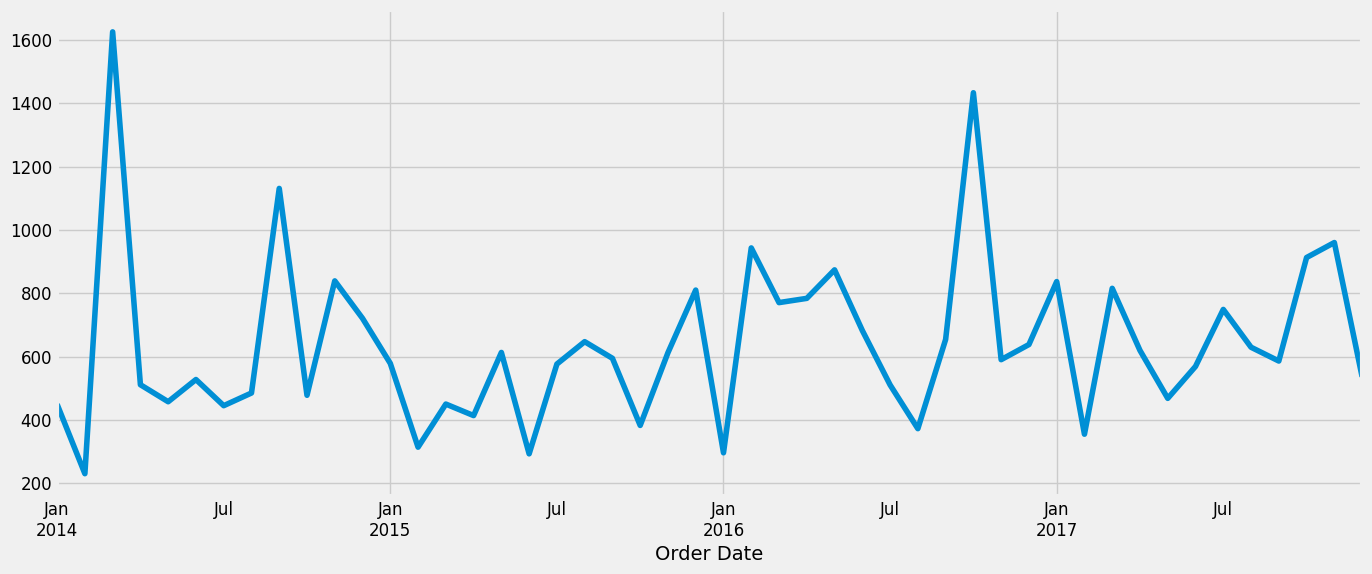

In [110]:
y['Sales'].plot(figsize=(15, 6))
plt.show()

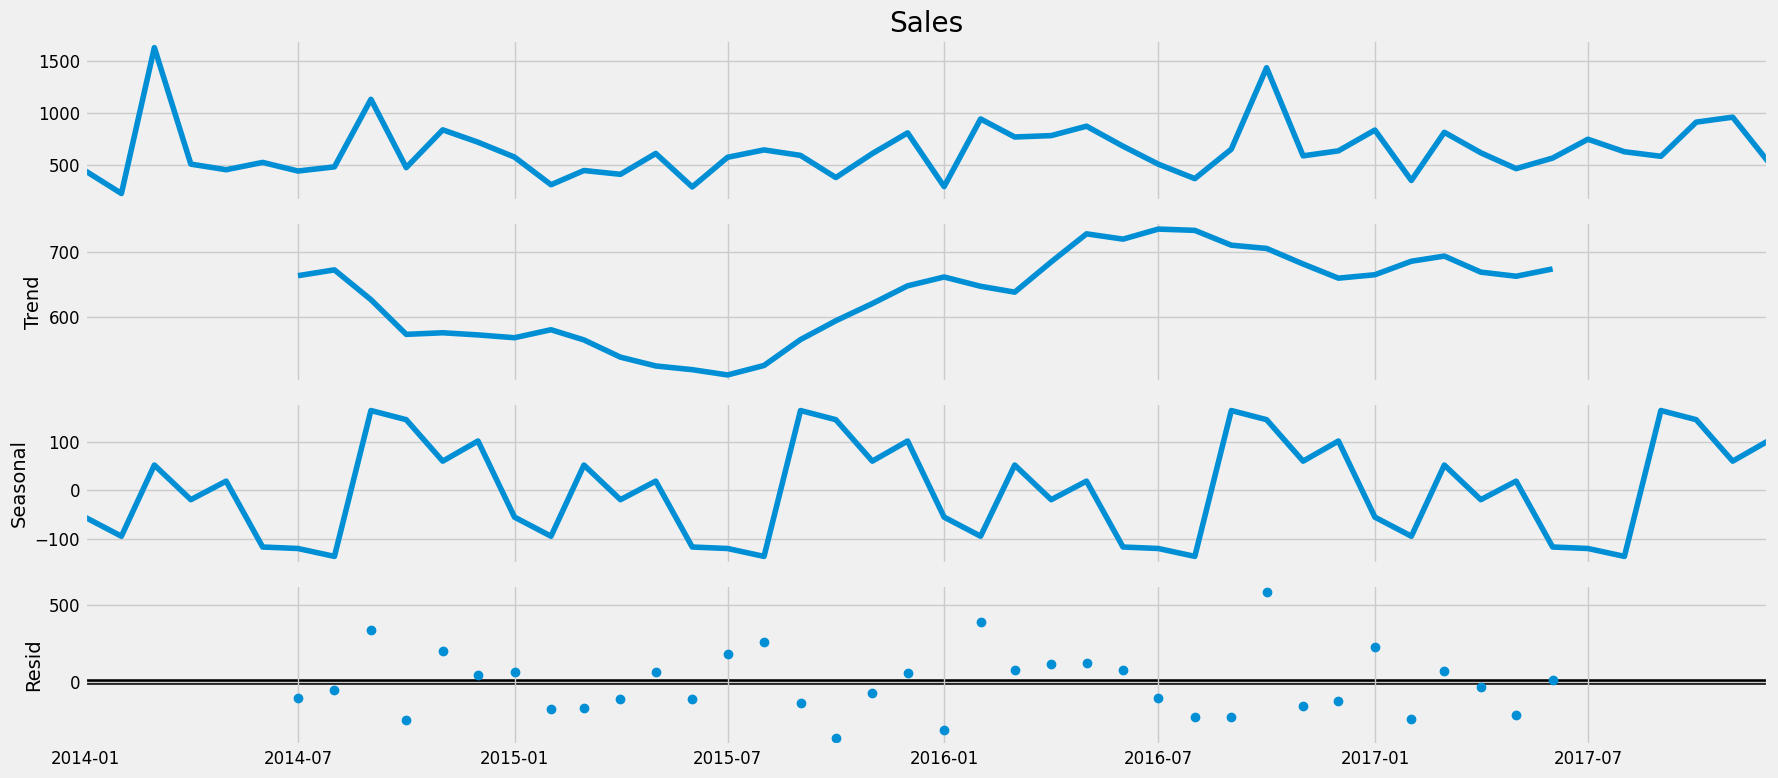

In [111]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y['Sales'], model='additive')
fig = decomposition.plot()
plt.show()
#positive trend post july 2015 and yearly seasonal trend

In [112]:
from statsmodels.tsa.stattools import adfuller

adfuller(y['Sales'])[1]
#pvalue less than 0.05 hence stationary time series

np.float64(9.321260565810907e-12)

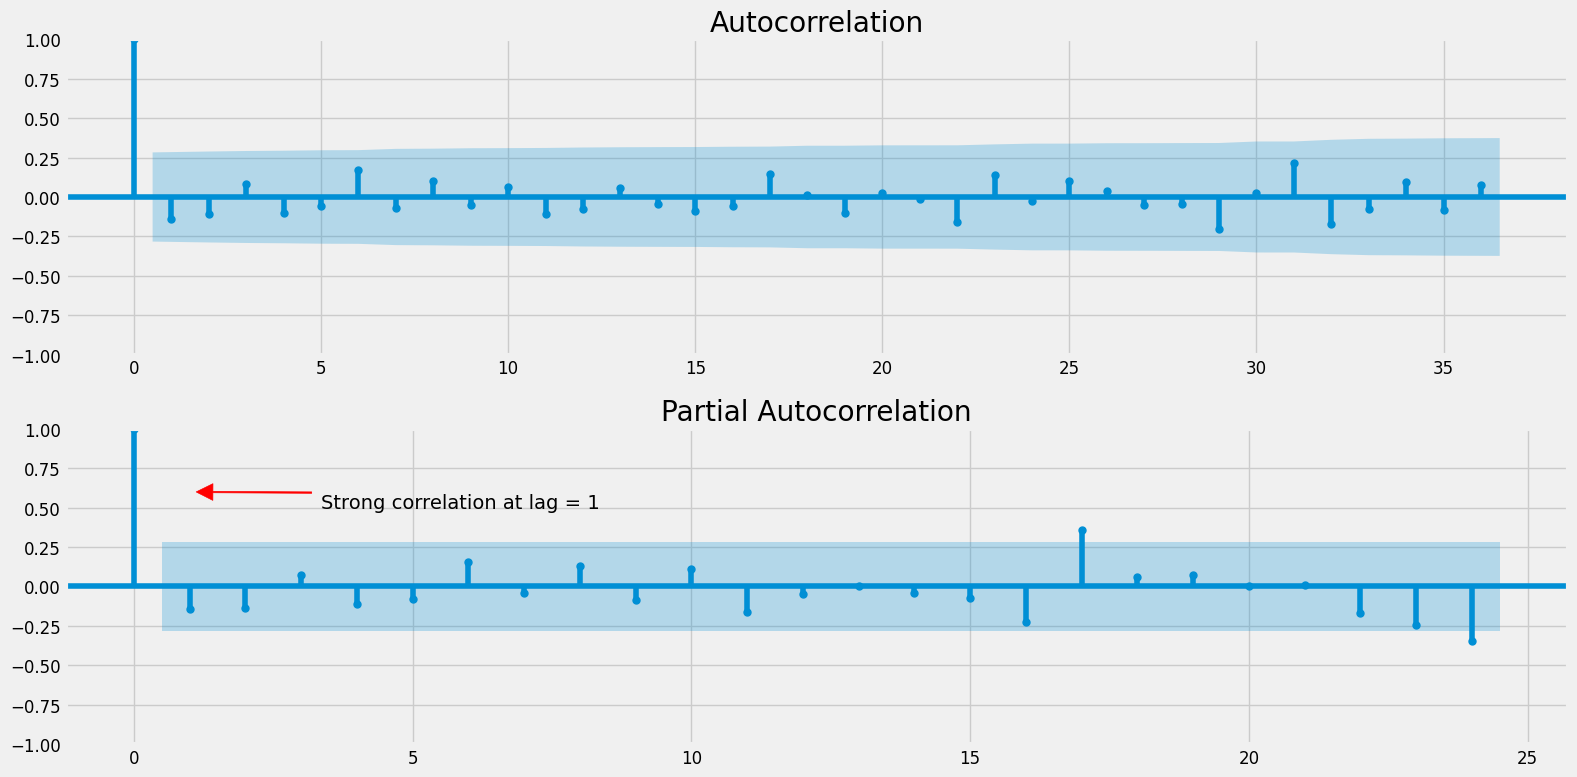

In [113]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
plot_acf(y['Sales'],lags=36, ax=ax[0])
plot_pacf(y['Sales'],lags=24, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
            xytext=(0.17, 0.75), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()
#no significant correlation between subsequent time series values, not in season pattern as well hence p and q can be set to 0

In [114]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [115]:
y[[i for i in y.columns if i != 'Sales']] = y[[i for i in y.columns if i != 'Sales']].astype(int)

In [116]:
m = 10000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y['2014':'31-12-2016']['Sales'],
                                            exog=y['2014':'31-12-2016'][[i for i in y.columns if i != 'Sales']],
                                            order=param,
                                            seasonal_order=param_seasonal)
        
            results = mod.fit()
            if results.aic<m:
                m = results.aic
                pr = param
                pr_s = param_seasonal
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as e:
            print(e)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:518.6136492953799
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:520.1103332475604
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:353.3232812329997
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:354.82056969564064
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:520.176576724543
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:522.0372152979172
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:354.82724663053943
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:356.8035647058144
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:520.2665557491341
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:521.643471953304
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:355.25053986530327
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:356.8130131153827
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:521.779099900642
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:523.4546888210302
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:356.8234510612938
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:358.79109885226364
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:522.10679843045
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:521.3036502655447
ARIMA(0, 1,

In [117]:
print(m,pr,pr_s)

343.0892125584649 (0, 1, 1) (0, 1, 0, 12)


In [118]:
mod = sm.tsa.statespace.SARIMAX(y['2014':'31-12-2016']['Sales'],
                                exog=y['2014':'31-12-2016'][[i for i in y.columns if i != 'Sales']],
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12))
results = mod.fit()
print(results.summary().tables[1])
#ma term and sigma term is not significant

                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Sub-Category_Copiers     34.8754    272.758      0.128      0.898    -499.720     569.470
Sub-Category_Machines   404.8618    172.727      2.344      0.019      66.323     743.400
ma.L1                    -0.8206      0.261     -3.150      0.002      -1.331      -0.310
ma.S.L12                 -0.0143      0.698     -0.021      0.984      -1.383       1.354
sigma2                 1.197e+05    3.1e+04      3.866      0.000     5.9e+04     1.8e+05


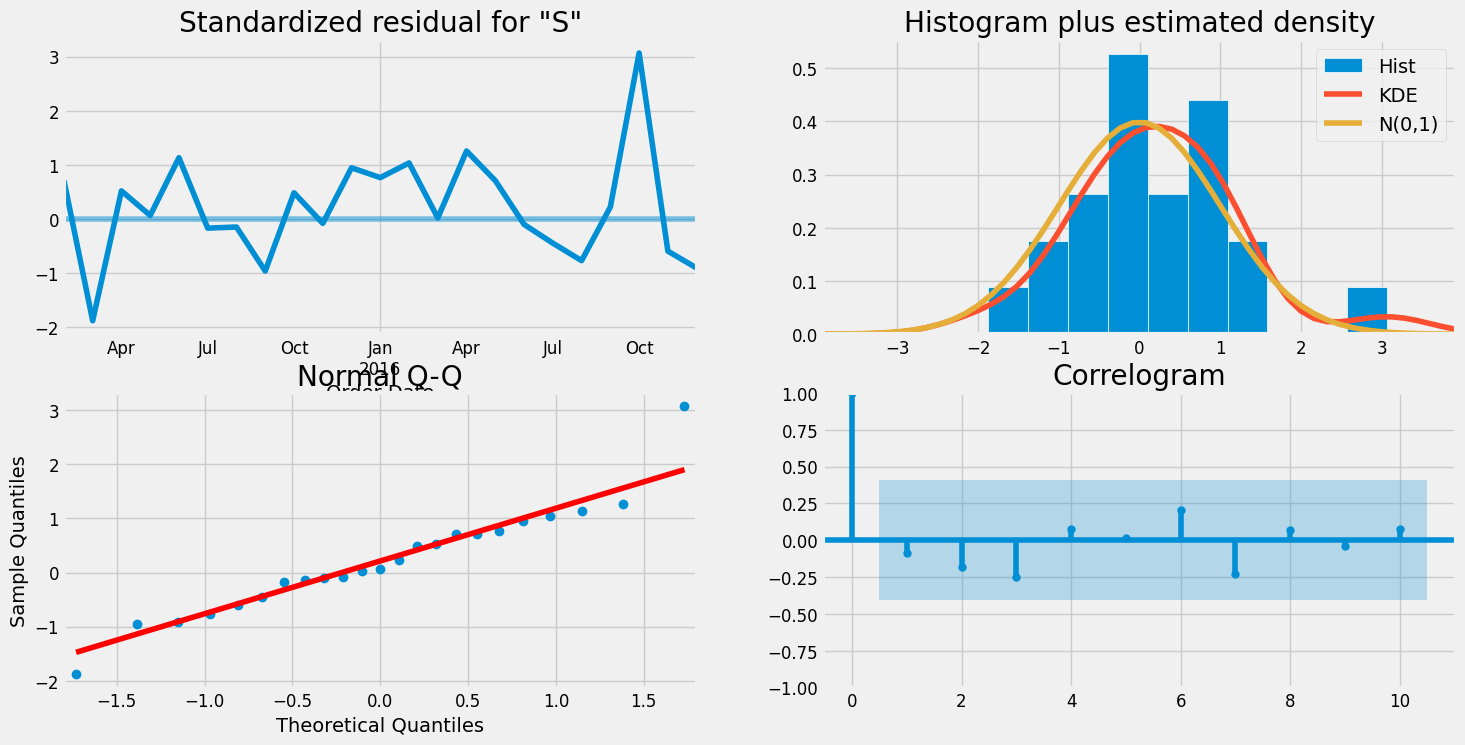

In [119]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

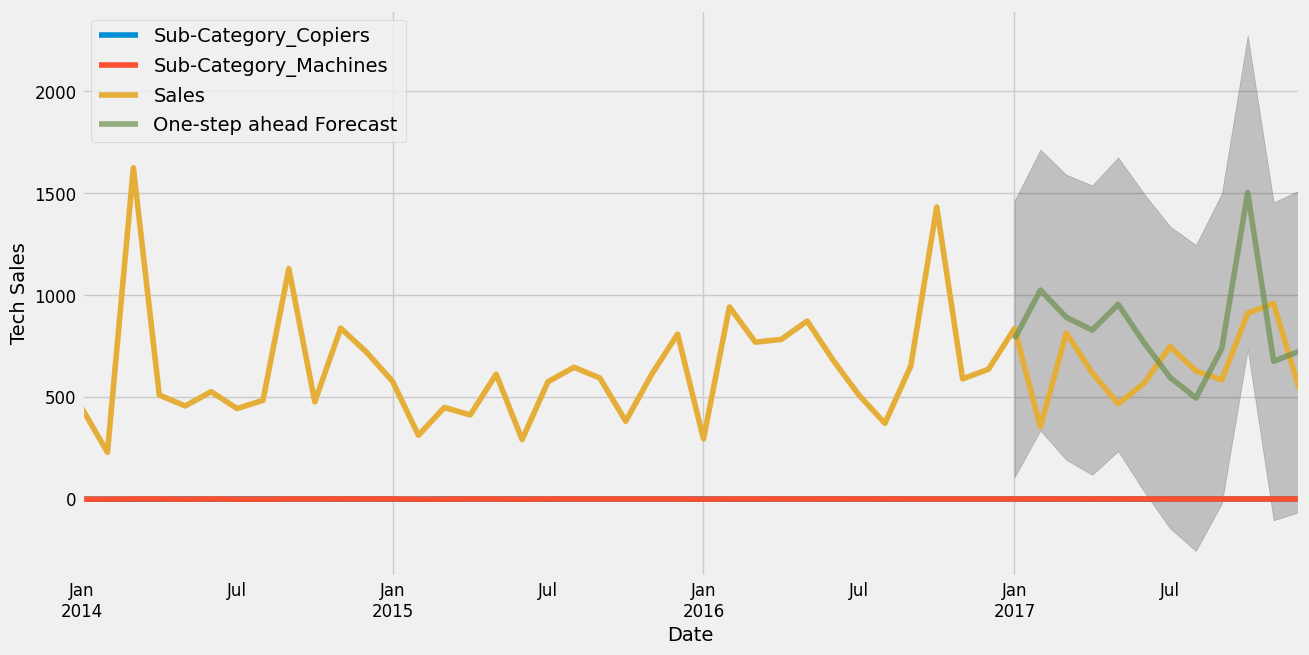

In [120]:
pred = results.get_forecast(steps=12,exog=y['2017':][[i for i in y.columns if i != 'Sales']])
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Tech Sales')
plt.legend()
plt.show()

In [121]:
y_forecasted = results.get_forecast(steps=12,exog=y['2017':][[i for i in y.columns if i != 'Sales']]).predicted_mean
y_truth = y['2017-01-01':]['Sales']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 109278.83


In [122]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 330.57


In [123]:
#SARIMA modelling
mod = sm.tsa.statespace.SARIMAX(y['2014':'31-12-2016']['Sales'],
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12))
results = mod.fit()
print(results.summary().tables[1])
#ma term and sigma term is not significant

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9967      9.230     -0.108      0.914     -19.086      17.093
ma.S.L12      -0.9682     18.429     -0.053      0.958     -37.089      35.152
sigma2      1.013e+05   1.69e+06      0.060      0.952   -3.21e+06    3.41e+06


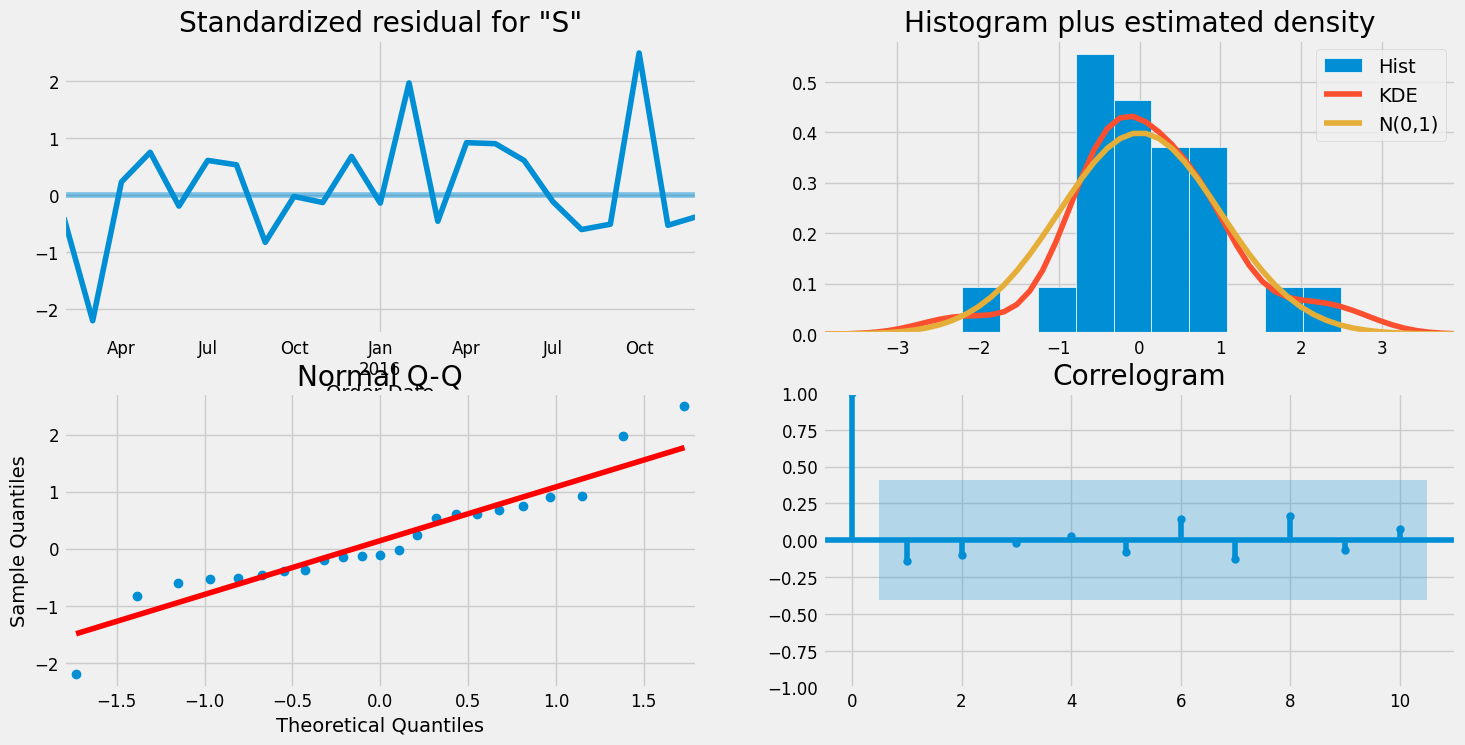

In [124]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

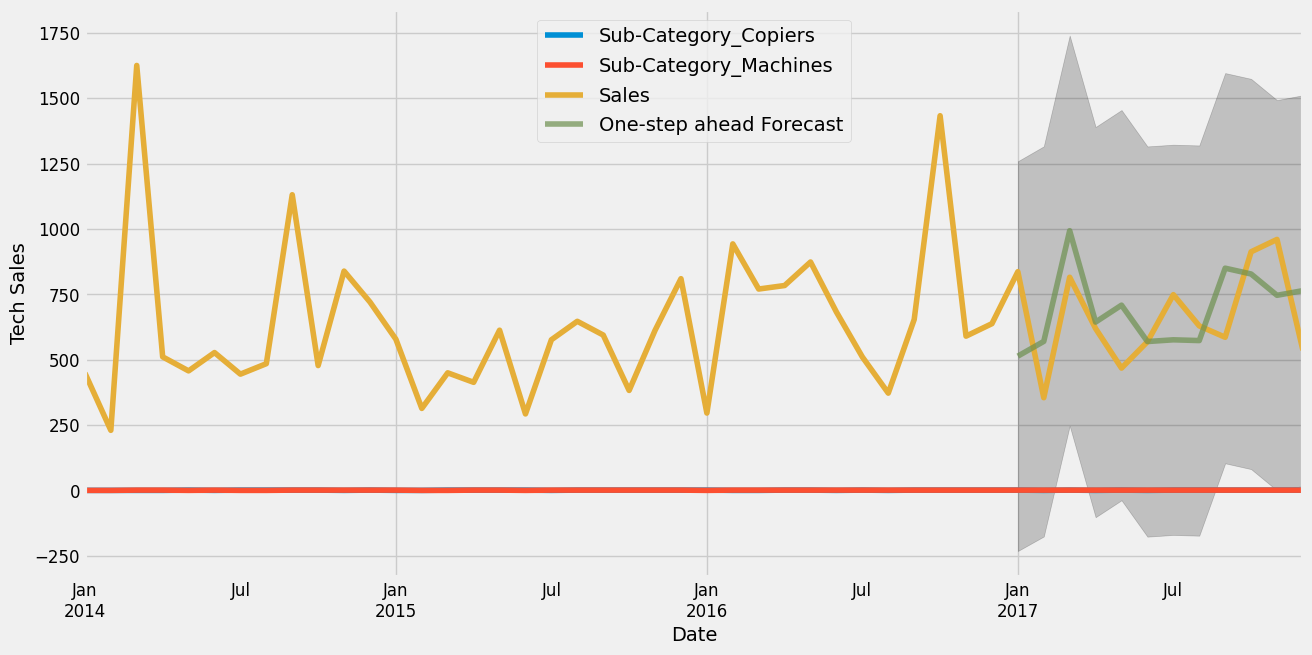

In [125]:
pred = results.get_forecast(steps=12)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Tech Sales')
plt.legend()
plt.show()

In [126]:
y_forecasted = results.get_forecast(steps=12).predicted_mean
y_truth = y['2017-01-01':]['Sales']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 37397.97


In [127]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 193.39


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9967      9.230     -0.108      0.914     -19.086      17.093
ma.S.L12      -0.9682     18.429     -0.053      0.958     -37.089      35.152
sigma2      1.013e+05   1.69e+06      0.060      0.952   -3.21e+06    3.41e+06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9985     17.485     -0.057      0.954     -35.268      33.270
ma.S.L12      -0.9831     22.826     -0.043      0.966     -45.721      43.754
sigma2      9.373e+04   2.22e+06      0.042      0.966   -4.26e+06    4.45e+06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9985     15.539     -0.064      0.9

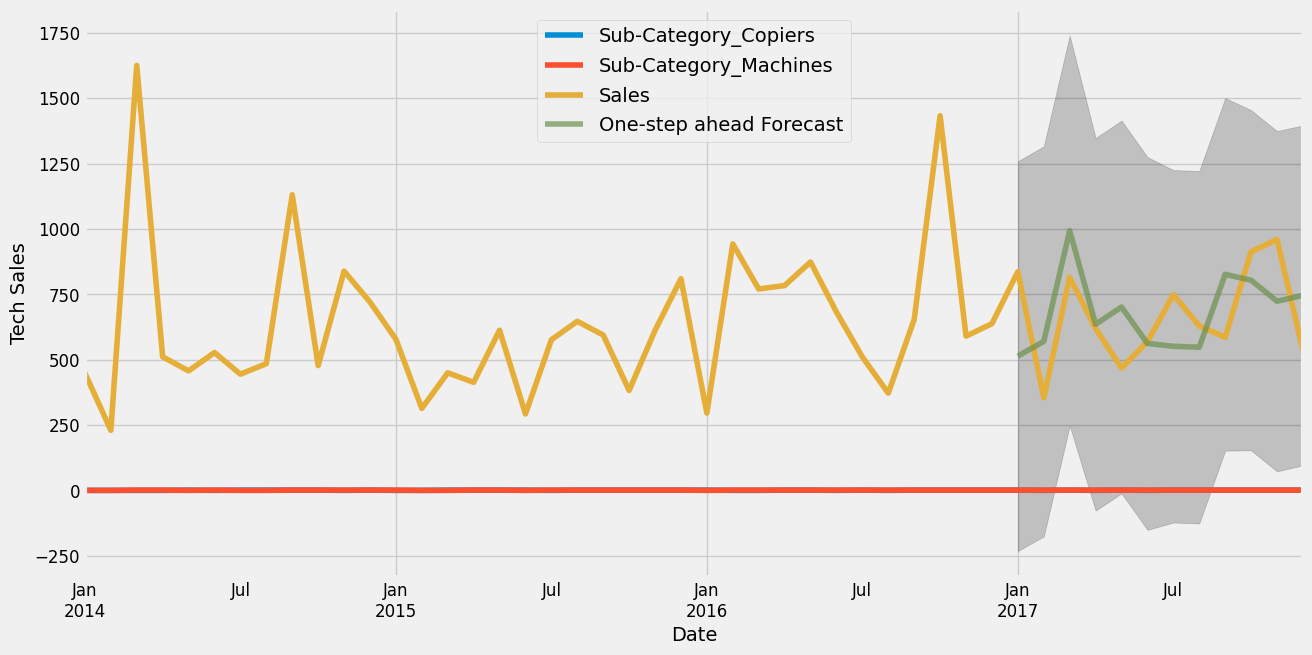

In [133]:
# Rolling average predictions
# quarterly window predictions

import datetime
from dateutil.relativedelta import relativedelta
y_forecasted = pd.Series([])
pred_ci = pd.Series([])
for i in range(4):
    mod = sm.tsa.statespace.SARIMAX(y['2014':datetime.date(2016,12,1)+relativedelta(months=3*i)]['Sales'],
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12))
    results = mod.fit()
    print(results.summary().tables[1])
    pred = results.get_forecast(steps=3)
    y_forecasted = pd.concat([y_forecasted,pred.predicted_mean])
    pred_ci =pd.concat([pred_ci,pred.conf_int()])
    
ax = y['2014':].plot(label='observed')
y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 1],
                pred_ci.iloc[:, 2], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Tech Sales')
plt.legend()
plt.show()


In [134]:
y_forecasted = results.get_forecast(steps=12).predicted_mean
y_truth = y['2017-01-01':]['Sales']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 37212.63


In [135]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 192.91
